In [30]:
import dataset_flickr
import helper_classes as helper
import nltk
#nltk.download('punkt')
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils import data as data
import model
import time 
import torch
import torch.nn as nn
import torch.optim as optim
import pathlib
import os 

In [31]:
CHECKPOINT_DIRECTORY = "model_checkpoints"

# Load Dataset

## Train set 

In [32]:
# dataset
data_args = {'stage': 'train',
            'ds_path' : "/home/Datasets/flickr30k/", 
            'captions_dir': "annotations",
            'captions_fname': 'results_new.csv',
            'images_dir': 'images_split',
            'freq_threshold': 5}
train_data = dataset_flickr.Flickr30kData(**data_args)
print(f"Initialized {len(train_data)} images!") 

stage:  train
ds_path:  /home/Datasets/flickr30k/
captions_f:  /home/Datasets/flickr30k/annotations/results_new.csv
imgs_dir:  /home/Datasets/flickr30k/images_split/train
Initialized 7736 words in vocabulary
Initialized 700 images!


## Validation set

In [33]:
# dataset
data_args = {'stage': 'val',
            'ds_path' : "/home/Datasets/flickr30k/", 
            'captions_dir': "annotations",
            'captions_fname': 'results_new.csv',
            'images_dir': 'images_split',
            'freq_threshold': 5}
val_data = dataset_flickr.Flickr30kData(**data_args)
print(f"Initialized {len(val_data)} images!") 

stage:  val
ds_path:  /home/Datasets/flickr30k/
captions_f:  /home/Datasets/flickr30k/annotations/results_new.csv
imgs_dir:  /home/Datasets/flickr30k/images_split/val
Initialized 7736 words in vocabulary
Initialized 100 images!


## Test set

In [34]:
# dataset
data_args = {'stage': 'test',
            'ds_path' : "/home/Datasets/flickr30k/", 
            'captions_dir': "annotations",
            'captions_fname': 'results_new.csv',
            'images_dir': 'images_split',
            'freq_threshold': 5}
test_data = dataset_flickr.Flickr30kData(**data_args)
print(f"Initialized {len(test_data)} images!") 

stage:  test
ds_path:  /home/Datasets/flickr30k/
captions_f:  /home/Datasets/flickr30k/annotations/results_new.csv
imgs_dir:  /home/Datasets/flickr30k/images_split/test
Initialized 7736 words in vocabulary
Initialized 200 images!


## Set up data loader

In [38]:
pad_idx = train_data.vocabulary.str_to_idx["<PAD>"]
batch_size = 32

train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=helper.CollateCustom(pad_idx),
    )


val_loader = DataLoader (
        dataset=val_data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=helper.CollateCustom(pad_idx),
    )


test_loader = DataLoader(
        dataset=val_data,
        batch_size=  1,
        shuffle=True,
        #collate_fn=helper_classes.CollateCustom(pad_idx),
    )


# Set up hyperparameters

In [40]:
"""
TODO:
- need to figure out train/val batch size 
- caption length - how to set this param? 
"""
# Hyperparameters
embed_size = 256
hidden_size = 256
vocab_size = len(train_data.vocabulary)
num_layers = 1
learning_rate = 3e-4

#dont train CNN from scratch
#tune last layer 
extract_features = True



# Initialize Model, Loss & optimizer

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [42]:
import model
model = model.EncodertoDecoder(embed_size, hidden_size, num_layers, vocab_size, extract_features).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=train_data.vocabulary.str_to_idx["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Initialized Encoder!
Initialized Decoder!


# Train model

In [44]:
"""
TODO:
add validation set? 
"""
#import pathlib
CHECKPOINT_DIRECTORY = "model_checkpoints"

model.train()

start = 0 
num_epochs = 20
losses = [] 

time_start = time.time() 

restore_latest_checkpoint = True

if restore_latest_checkpoint:
    #find last checkpoint file based on last modified 
    all_files = pathlib.Path(CHECKPOINT_DIRECTORY).glob('*.pth')
    latest_file = max(all_files, key=os.path.getctime)
    checkpoint_file = str(latest_file).split("/")[1]
    
    #adjust epoch range
    start = int(checkpoint_file.split("_")[2]) + 1 
    num_epochs += start 
    
    
    #load checkpoint 
    helper.load_checkpoint("basic_model_100_epochs.pth", model, optimizer)

for epoch in range(start, num_epochs+1):
        for batch_num, (idx, X, y) in enumerate(train_loader):

            X = X.to(device)
            y = y.to(device)

            outputs = model(X, y[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), y.reshape(-1)
            )

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()
        
        #save loss after every epoch 
        losses.append(loss.item())
        
        #save every 10 epochs
        if epoch%10 == 0:
            
            print(f"Training loss after {epoch} epochs: {loss.item()}")
            
            #save checkpoint 
            checkpoint = {"state_dict": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "step": epoch
                        }
            fname = "basic_model_" + str(epoch) + "_epochs.pth"
            helper.save_checkpoint(checkpoint, fname)
        
        #for final epoch 
        if epoch == num_epochs: 
            helper.save_model(model.state_dict(), "basic_model.pth")
            
print("Time elapsed for {} epochs: {} min".format(num_epochs, 
                                                  round((time.time()-time_start)/60, 2)))
print("loss: ", loss.item())

Loaded checkpoint basic_model_100_epochs.pth!
Training loss after 110 epochs: 1.036096215248108
Saved checkpoint basic_model_110_epochs.pth!
Training loss after 120 epochs: 0.9861122965812683
Saved checkpoint basic_model_120_epochs.pth!
Saved model basic_model.pth!
Time elapsed for 121 epochs: 3.12 min
loss:  0.9829516410827637


## Plot loss 

<AxesSubplot:xlabel='epochs', ylabel='loss'>

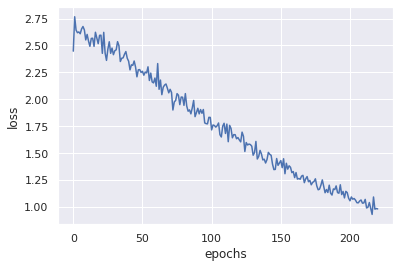

In [45]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd
sns.set() 


if restore_latest_checkpoint:
    #add to existing losses 
    old_losses = pd.read_csv('loss.csv')[["epochs", "loss"]]
    start_index = old_losses.epochs.max() + 1
    new_data = [[start_index+i, losses[i]] for i in range(len(losses))]
    new_losses = pd.DataFrame(new_data, columns = ["epochs", "loss"])
    loss_df = pd.concat([old_losses, new_losses], keys = ["epochs", "loss"]).reset_index(drop = True)
    
else:
    #create new df 
    loss_df = pd.DataFrame(losses, columns = ['loss'])
    loss_df = loss_df.reset_index().rename(columns= {'index': 'epochs'})
    
loss_df.to_csv("loss.csv")

sns.lineplot(data = loss_df, x = "epochs", y = "loss") 

## Test random cases

In [ ]:
#Load model for inference 
model = model.EncodertoDecoder(embed_size, hidden_size, num_layers, vocab_size, extract_features).to(device)
load_model(model, "basic_model.pth")
model.eval()
None

In [46]:
idx, X, y= next(iter(train_loader))

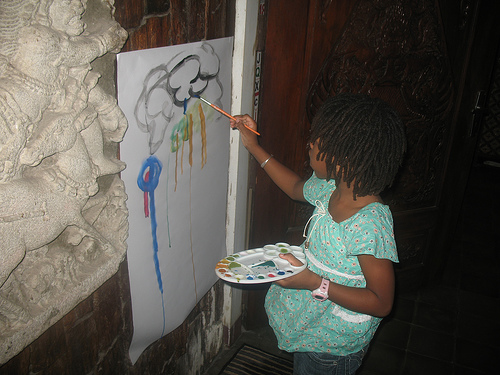

In [49]:
#val_data.plot_img(idx.item())
train_data.plot_img(idx[1])

In [50]:
"""
TODO: when calculating score, compare to any of the reference sentence?
"""
print("Expected: ", train_data.get_image_caption(idx[1]))
print("Predicted: ", model.caption_image(X[1:2].to(device), train_data.vocabulary))


#print("Expected: ", val_data.get_image_caption(idx.item()))
#print("Predicted: ", model.caption_image(X.to(device), test_data.vocabulary))

Expected:  A young girl with braids is painting with water colors on a white paper on the wall .
Predicted:  ['<SOS>', 'a', 'man', 'in', 'a', 'black', 'shirt', 'and', 'jeans', 'walks', 'beside', 'a', 'woman', 'in', 'a', 'black', 'shirt', ',', 'standing', 'in']


In [52]:
#expected = val_data.get_image_caption(idx.item()).split(" ")
#print(expected)
#predicted = model.caption_image(X.to(device), test_data.vocabulary)
#print(predicted)

In [53]:
from nltk.translate.bleu_score import sentence_bleu

#score = sentence_bleu(expected, predicted)
#print(score)